In [1]:
# Standard library
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and modeling
from scipy import stats
from sklearn.metrics import * # Add/remove as needed
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import powerlaw as pl  # Avoid conflict with scipy.stats.powerlaw


# Get the current working directory and then go up to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

In [2]:
message_data = pd.read_csv("combined_messages_2024-08-12.csv")
# message_data = pd.read_csv("combined_messages_.csv")

message_column_names = [
    'Time',         # Seconds after midnight with decimal precision
    'EventType',    # Type of event (1 to 7 as described)
    'OrderID',      # Unique order reference number
    'Size',         # Number of shares
    'Price',        # Dollar price times 10000
    'Direction',     # -1 for sell, 1 for buy
    # 'NotUsed',      # Not used, for alignment purposes
]

message_data.columns = message_column_names

print(message_data.shape)

# Drop first row
message_data = message_data.drop(0)

# Drop NotUsed column
# message_data = message_data.drop(columns=['NotUsed'])

(1438228, 6)


In [3]:
book_data = pd.read_csv("combined_orderbooks_2024-08-12.csv")
# book_data = pd.read_csv("combined_orderbooks_.csv")

# Define the column names up to level 10
column_names = []
for level in range(1, 11):
    column_names.extend([
        f'AskPrice{level}', f'AskSize{level}',
        f'BidPrice{level}', f'BidSize{level}'
    ])

# Set the column names for the DataFrame
book_data.columns = column_names

print(book_data.shape)

# Drop first row
book_data = book_data.drop(0)

(1438228, 40)


In [4]:
# if Time index stil exists, execute; otherwise skip
# Directly copy the 'Time' column from message_data to book_data
book_data['Time'] = message_data['Time']

# Reorder columns to make 'Time' the first column
# This assumes book_data originally had unnamed columns
columns = ['Time'] + list(book_data.columns[:-1])  # Move 'Time' to the first position
book_data = book_data[columns]

message_data['Time'] = pd.to_datetime(message_data['Time'])
book_data['Time'] = pd.to_datetime(book_data['Time'])

# set index only if not already set to avoid runtime error
if not message_data.index.name == 'Time':
    message_data.set_index('Time', inplace=True)

if not book_data.index.name == 'Time':
    book_data.set_index('Time', inplace=True)

In [5]:
# Mid-price calculation
book_data['MidPrice'] = (book_data['AskPrice1'] + book_data['BidPrice1']) / 2

message_data['MidPrice'] = book_data['MidPrice']

message_data['BestBid'] = book_data['BidPrice1']

message_data['BestAsk'] = book_data['AskPrice1']

In [6]:
# Optional: time trimming
# Take data from 11:00 to 11:30 on 2024-08-12
start_time = '2024-08-12 11:00:00'
end_time = '2024-08-12 12:00:00'

# Convert to datetime
start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

print(type(start_time))

# deep copy original data before filtering
original_message_data = message_data.copy(deep=True)
original_book_data = book_data.copy(deep=True)

# Filter data for the specified time range
message_data = message_data[(message_data.index >= start_time) & (message_data.index <= end_time)]
book_data = book_data[(book_data.index >= start_time) & (book_data.index <= end_time)]


<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [7]:
message_data.head()

,EventType,OrderID,Size,Price,Direction,MidPrice,BestBid,BestAsk
Time,,,,,,,,
2024-08-12 11:00:00.007273984,3,194931721,100,1681000,-1,1680650.0,1680500,1680800
2024-08-12 11:00:00.007281920,3,194932409,100,1681100,-1,1680650.0,1680500,1680800
2024-08-12 11:00:00.007372544,3,195196037,100,1680300,1,1680650.0,1680500,1680800
2024-08-12 11:00:00.009021184,3,194928185,100,1681200,-1,1680650.0,1680500,1680800
2024-08-12 11:00:00.010997248,1,195283545,50,1680500,1,1680650.0,1680500,1680800


In [8]:
book_data.head()

,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,...,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10,MidPrice
Time,,,,,,,,,,,,,,,,,,,,,
2024-08-12 11:00:00.007273984,1680800,225,1680500,102,1680900,191,1680400,810,1681000,325,...,408,1681600,529,1679700,281,1681700,309,1679600,258,1680650.0
2024-08-12 11:00:00.007281920,1680800,225,1680500,102,1680900,191,1680400,810,1681000,325,...,408,1681600,529,1679700,281,1681700,309,1679600,258,1680650.0
2024-08-12 11:00:00.007372544,1680800,225,1680500,102,1680900,191,1680400,810,1681000,325,...,408,1681600,529,1679700,281,1681700,309,1679600,258,1680650.0
2024-08-12 11:00:00.009021184,1680800,225,1680500,102,1680900,191,1680400,810,1681000,325,...,408,1681600,529,1679700,281,1681700,309,1679600,258,1680650.0
2024-08-12 11:00:00.010997248,1680800,225,1680500,152,1680900,191,1680400,810,1681000,325,...,408,1681600,529,1679700,281,1681700,309,1679600,258,1680650.0


### Mid-price Dynamics

In [9]:
# Calculate a column called mid-price difference
book_data['MidPriceDiff'] = book_data['MidPrice'].diff()

# drop the first row
book_data = book_data.dropna()

# divide by 1000 get the actual price difference
book_data['MidPriceDiff'] = book_data['MidPriceDiff'] / 10000

# also the MidPrice
book_data['MidPrice'] = book_data['MidPrice'] / 10000

book_data.head()

,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,...,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10,MidPrice,MidPriceDiff
Time,,,,,,,,,,,,,,,,,,,,,
2024-08-12 11:00:00.007281920,1680800,225,1680500,102,1680900,191,1680400,810,1681000,325,...,1681600,529,1679700,281,1681700,309,1679600,258,168.065,0.0
2024-08-12 11:00:00.007372544,1680800,225,1680500,102,1680900,191,1680400,810,1681000,325,...,1681600,529,1679700,281,1681700,309,1679600,258,168.065,0.0
2024-08-12 11:00:00.009021184,1680800,225,1680500,102,1680900,191,1680400,810,1681000,325,...,1681600,529,1679700,281,1681700,309,1679600,258,168.065,0.0
2024-08-12 11:00:00.010997248,1680800,225,1680500,152,1680900,191,1680400,810,1681000,325,...,1681600,529,1679700,281,1681700,309,1679600,258,168.065,0.0
2024-08-12 11:00:00.024966656,1680800,225,1680500,152,1680900,191,1680400,710,1681000,325,...,1681600,529,1679700,281,1681700,309,1679600,258,168.065,0.0


In [10]:
# Join book data but only the MidPriceDiff column with message data on index
if 'MidPriceDiff' not in message_data.columns:
    message_data = message_data.join(book_data['MidPriceDiff'])

# only consider MO executions
# That is EventType 4 and 5
message_data = message_data[(message_data['EventType'] == 4) | (message_data['EventType'] == 5)]

message_data.head(20)

,EventType,OrderID,Size,Price,Direction,MidPrice,BestBid,BestAsk,MidPriceDiff
Time,,,,,,,,,
2024-08-12 11:00:00.119292416,4,194940277,73,1680800,-1,1680750.0,1680700,1680800,0.000
2024-08-12 11:00:00.119320320,4,194940277,27,1680800,-1,1680800.0,1680700,1680900,0.005
2024-08-12 11:00:00.131929088,4,183158885,5,1681000,-1,1680950.0,1680900,1681000,0.000
2024-08-12 11:00:00.131929088,4,183158885,5,1681000,-1,1680950.0,1680900,1681000,0.000
2024-08-12 11:00:00.131929088,4,187005957,10,1681000,-1,1680950.0,1680900,1681000,0.000
2024-08-12 11:00:00.131929088,4,187005957,10,1681000,-1,1680950.0,1680900,1681000,0.000
2024-08-12 11:00:00.131929856,4,187005957,11,1681000,-1,1680950.0,1680900,1681000,0.000
2024-08-12 11:00:00.131944704,4,187005957,29,1681000,-1,1680950.0,1680900,1681000,0.000
2024-08-12 11:00:00.131944704,4,187005957,29,1681000,-1,1680950.0,1680900,1681000,0.000


In [11]:
# prepare a counter function called Mt_plus and Mt_minus
# Mt_plus counts the number of MO arrival for buy MO (Direction = 1)
# Mt_minus counts the number of MO arrival for sell MO (Direction = -1)
# So it is simply a proxy of Direction column, but transformed to 1 and 0

message_data['Mt_plus'] = message_data['Direction'].apply(lambda x: 1 if x == 1 else 0)
message_data['Mt_minus'] = message_data['Direction'].apply(lambda x: 1 if x == -1 else 0)

In [12]:
# Another column called NormalizedMidPrice
# where simply set the first recorded mid-price as 0
# and then calculate the difference with the first mid-price

# divide mid price by 10000
message_data['MidPrice'] = message_data['MidPrice'] / 10000

initial_mid_price = message_data['MidPrice'].iloc[0]

message_data['NormalizedMidPrice'] = message_data['MidPrice'] - initial_mid_price

message_data.head()

,EventType,OrderID,Size,Price,Direction,MidPrice,BestBid,BestAsk,MidPriceDiff,Mt_plus,Mt_minus,NormalizedMidPrice
Time,,,,,,,,,,,,
2024-08-12 11:00:00.119292416,4,194940277,73,1680800,-1,168.075,1680700,1680800,0.000,0,1,0.000
2024-08-12 11:00:00.119320320,4,194940277,27,1680800,-1,168.080,1680700,1680900,0.005,0,1,0.005
2024-08-12 11:00:00.131929088,4,183158885,5,1681000,-1,168.095,1680900,1681000,0.000,0,1,0.020
2024-08-12 11:00:00.131929088,4,183158885,5,1681000,-1,168.095,1680900,1681000,0.000,0,1,0.020
2024-08-12 11:00:00.131929088,4,187005957,10,1681000,-1,168.095,1680900,1681000,0.000,0,1,0.020


In [13]:
# Run a linear regression to estinate parameters
# Dependent variable is MidPriceDiff
# Independent variables are Mt_plus and Mt_minus and NormalizedMidPrice

# Feature Mt_minus and and NormalizedMidPrice is expected to have a negative effect on MidPriceDiff
# So to keep the result coefficients in the same direction, we will multiply Mt_minus and NormalizedMidPrice by -1

# Step 1: Response
Y = message_data['MidPriceDiff'].values

# Step 2: Design matrix (three columns)
#   col1 = +Mt_plus         -> coefficient = epsilon^+
#   col2 = -(Mt_minus)      -> coefficient = epsilon^-
#   col3 = -(NormalizedMidPrice) -> coefficient = zeta
X = np.column_stack((
    message_data['Mt_plus'].values,
    -message_data['Mt_minus'].values,
    -message_data['NormalizedMidPrice'].values
))

print(Y.shape, X.shape)

# Step 3: Fit regression (no intercept)
model = sm.GLS(Y, X).fit()
print(model.summary())

# Step 4: Extract parameter estimates
beta_hat = model.params  # array of length 3

eps_plus_hat   = beta_hat[0]
eps_minus_hat  = beta_hat[1]
zeta_hat       = beta_hat[2]

# Step 5: Compute residual-based estimate of sigma_alpha
residuals = model.resid
N = len(residuals)
p = 3  # number of parameters in the drift
sigma_alpha_est = np.sqrt(np.sum(residuals**2) / (N - p))

print("Estimated epsilon^+:",   eps_plus_hat)
print("Estimated epsilon^-:",   eps_minus_hat)
print("Estimated zeta:",        zeta_hat)
print("Estimated sigma_alpha:", sigma_alpha_est)



(44853,) (44853, 3)
                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.213
Model:                            GLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     6084.
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:56:08   Log-Likelihood:             2.1067e+05
No. Observations:               44853   AIC:                        -4.213e+05
Df Residuals:                   44850   BIC:                        -4.213e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0009    1.9e-05

In [14]:
# Check timeframe
print(message_data.index.min())
print(message_data.index.max())

2024-08-12 11:00:00.119292416
2024-08-12 11:59:57.054863616


## Testing Case 15:00 - 16:00

Size of test data: 191161
Estimated epsilon^+: -0.000894211452912324
Estimated epsilon^-: -0.0017976280942410513
Estimated zeta: 0.0002140292307350512
Estimated sigma_alpha: 0.0022074578664978005


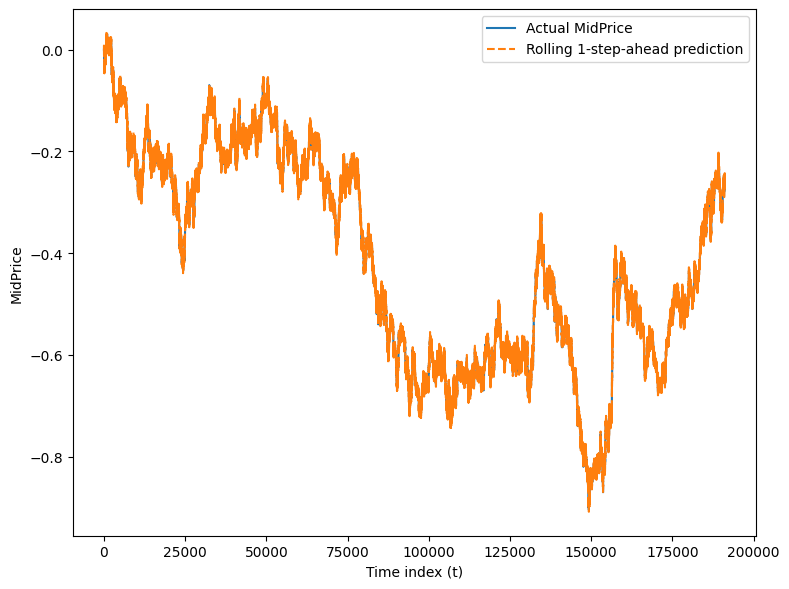

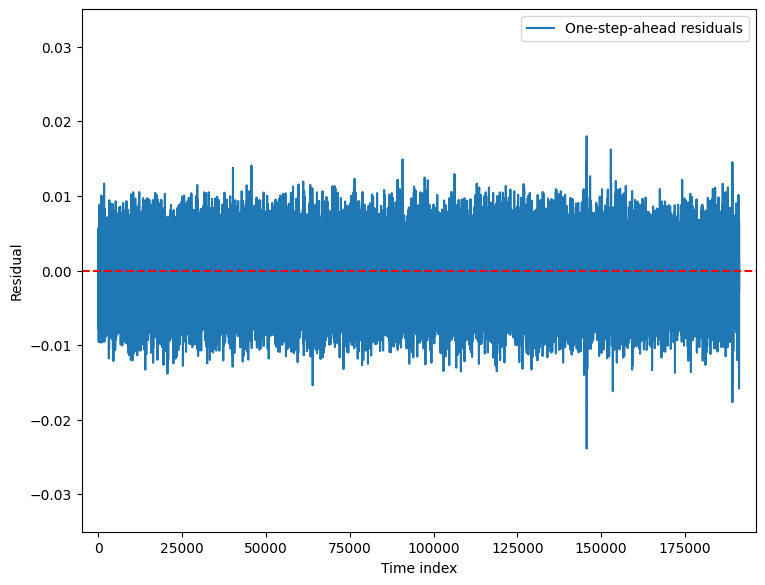

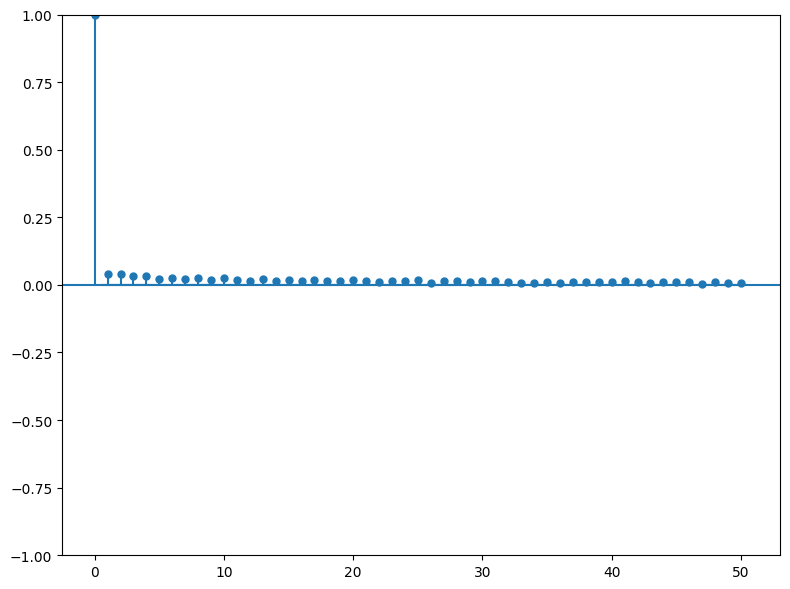

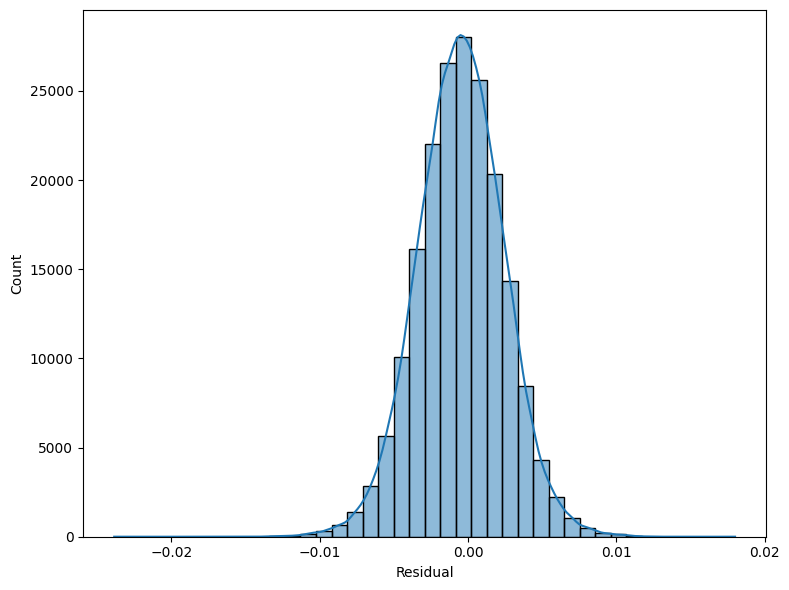

Mean Error       = -0.0005
MAE   = 0.0023
RMSE        = 0.0030


In [15]:
# Optional: time trimming
# Take data from 11:00 to 11:30 on 2024-08-12
start_time = '2024-08-12 15:00:00'
end_time = '2024-08-12 16:00:00'

# Convert to datetime
start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

# Filter data for the specified time range
test_message_data = original_message_data[(original_message_data.index >= start_time) & (original_message_data.index <= end_time)]
test_book_data = original_book_data[(original_book_data.index >= start_time) & (original_book_data.index <= end_time)]

# divide MidPrice by 10000
test_message_data['MidPrice'] = test_message_data['MidPrice'] / 10000

# Calculate NormalizedMidPrice column
test_initial_mid_price = test_message_data['MidPrice'].iloc[0]

test_message_data['NormalizedMidPrice'] = test_message_data['MidPrice'] - test_initial_mid_price

test_message_data['Mt_plus'] = test_message_data['Direction'].apply(lambda x: 1 if x == 1 else 0)
test_message_data['Mt_minus'] = test_message_data['Direction'].apply(lambda x: 1 if x == -1 else 0)

# test_message_data['Mt_plus'] = test_message_data['Mt_plus'] * test_message_data['Size']
# test_message_data['Mt_minus'] = test_message_data['Mt_minus'] * test_message_data['Size']

alpha_actual = test_message_data['NormalizedMidPrice'].values
Mt_plus = test_message_data['Mt_plus'].values
Mt_minus = test_message_data['Mt_minus'].values

N = len(alpha_actual)
rolling_alpha_pred = np.zeros(N)
rolling_alpha_pred[0] = alpha_actual[0]  # The first "prediction" can just match the actual

for t in range(N - 1):
    # Compute one-step increment dAlpha using the ACTUAL alpha at time t
    dAlpha = -zeta_hat * alpha_actual[t] \
             + eps_plus_hat  * Mt_plus[t] \
             - eps_minus_hat * Mt_minus[t] \
             + np.random.normal(0, sigma_alpha_est)
    # The one-step-ahead forecast for alpha_{t+1} based on alpha_{t}
    rolling_alpha_pred[t+1] = alpha_actual[t] + dAlpha

# Clear print the parameters we used
print("Size of test data:", N)  
print("Estimated epsilon^+:",   eps_plus_hat)
print("Estimated epsilon^-:",   eps_minus_hat)
print("Estimated zeta:",        zeta_hat)
print("Estimated sigma_alpha:", sigma_alpha_est)

# Set a consistent figure size
FIGSIZE = (8, 6)

# 1. Prediction vs. Actual Mid-Price
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(alpha_actual, label='Actual MidPrice')
ax.plot(rolling_alpha_pred, label='Rolling 1-step-ahead prediction', linestyle='--')
ax.set_xlabel('Time index (t)')
ax.set_ylabel('MidPrice')
# ax.set_title("Prediction vs. Actual Mid-Price", fontsize=15, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# 2. Residuals Over Time
residuals_1step = alpha_actual - rolling_alpha_pred
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(residuals_1step, label='One-step-ahead residuals')
ax.axhline(y=0, color='r', linestyle='--')
# ax.set_title("Residuals Over Time", fontsize=15, fontweight='bold')
ax.set_xlabel("Time index")
ax.set_ylabel("Residual")
ax.legend()
plt.tight_layout()
plt.xlim(0-5000, N+5000)
plt.ylim(-0.035, 0.035)
plt.show()

# 3. Autocorrelation of Residuals
fig, ax = plt.subplots(figsize=FIGSIZE)
sm.graphics.tsa.plot_acf(residuals_1step, lags=50, ax=ax, title="")
# ax.set_title("ACF of Residuals", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Histogram of Residuals
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.histplot(residuals_1step, kde=True, bins=40, ax=ax)
# ax.set_title("Histogram of Residuals", fontsize=15, fontweight='bold')
ax.set_xlabel("Residual")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


# Calculate key numerical metrics 
ME = np.mean(residuals_1step)
MAE = mean_absolute_error(alpha_actual, rolling_alpha_pred)
MSE = mean_squared_error(alpha_actual, rolling_alpha_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Error       = {ME:.4f}")
print(f"MAE   = {MAE:.4f}")
print(f"RMSE        = {RMSE:.4f}")
